In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path|
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

In [2]:
class setup:
    dummy = 0

def t_coeff(n):
    '''
    Returns t-test coefficient
    n -- number of points
    '''
    assert n > 0, 'n must be positive'
    __students = [12.7062, 4.3027, 3.1824, 2.7764, 2.5706, 2.4469, 2.3646, 2.3060, 2.2622]
    if n < len(__students):
        return __students[n-1]
    else:
        return 2

In [3]:
class Spectrum:
    def __init__(self, data):
        self.wavelen = data["Wavelength"]
        self.intensity = data["Intensity"]

class SpectrumFile:
    def __init__(self, file, noise):
        spectrum_data = pd.read_csv( file, skiprows=13, delimiter='\t', names=["Wavelength", "Intensity"],
                                     dtype=np.float64, decimal=',')
        noise_data = pd.read_csv( noise, skiprows=13, delimiter='\t', names=["Wavelength", "Intensity"],
                                  dtype=np.float64, decimal=',')
        
        self.noise = Spectrum( noise_data)
        self.spectrum = Spectrum( spectrum_data)
        
        norm = self.spectrum.intensity.max()
        self.spectrum.intensity = self.spectrum.intensity / norm
        self.noise.intensity = self.noise.intensity / norm
        

spectra = { 
    "air" : SpectrumFile( "data/air_spectrum.txt", "data/air_noise.txt"),
    "water" : SpectrumFile( "data/water_spectrum.txt", "data/water_noise.txt"),
    "lamp_sharovaya" : SpectrumFile( "data/lamp_sharovaya_spectrum.txt", "data/lamp_sharovaya_noise.txt"),
    "lamp_tube" : SpectrumFile( "data/lamp_tube_spectrum.txt", "data/lamp_tube_noise.txt"),
}

In [114]:
import itertools

def spectrum_lines( file, n_lines = 40):
    lines_df = pd.read_csv( file, delimiter=',', dtype=np.float64, decimal='.')
    
    lines = {}
    for elem in lines_df.columns[1:]:        
        elem_lines = lines_df.get( ['Wavelength', elem]).dropna()
        elem_lines = elem_lines.sort_values( by = [elem])[-n_lines:]
        lines[elem] = np.sort( elem_lines['Wavelength'].to_numpy())

    return lines


COLORS = itertools.cycle(['green', 'blue', 'orange', 'red', 'yellow'])
def show_spectrum_lines( elem_lines, label, waverange, color = None, plot = plt):
    low_index, high_index = get_safe_range( elem_lines, waverange)
    plot.vlines( elem_lines[low_index:high_index], 0, 1, colors=color, linestyles='solid', label=label, linewidth = 0.5)

def show_all_spectrum_lines( lines, waverange, plot = plt ):
    color = itertools.cycle(['green', 'blue', 'orange', 'red', 'yellow'])
    for key in lines:
        show_spectrum_lines( lines[key], key, waverange, color = next(COLORS), plot = plot)

def show_named_spectrum_lines( lines, names, waverange, plot = plt ):
    color = itertools.cycle(['green', 'blue', 'orange', 'red', 'yellow'])
    for key in names:
        show_spectrum_lines( lines[key], key, waverange, color = next(COLORS), plot = plot)        
        

In [198]:
np.full((len(_lines)), color)

NameError: name '_lines' is not defined

In [50]:
def get_safe_range( data, safe_range):
    if data.min() > safe_range[1] or data.max() < safe_range[0]:
        print('AHTUNG!')
        return 0, 0;
    
    low_index  = np.argmax( data >= safe_range[0])
    high_index = np.argmax( data >= safe_range[1])
    
    if high_index == 0:
        high_index = len(data)
    print(low_index)
    print(high_index)
    return low_index, high_index

## Spectra

In [79]:
from scipy.interpolate import splrep, BSpline

def show_spectrum( spec, s, waverange, plot = plt):


    assert spec.spectrum.wavelen.size == spec.noise.wavelen.size
    
    low_index, high_index = get_safe_range( spec.spectrum.wavelen, waverange)

    spectrum_x = spec.spectrum.wavelen[low_index:high_index]
    spectrum_y = spec.spectrum.intensity[low_index:high_index]
    noise_x    = spec.noise.wavelen[low_index:high_index]
    noise_y    = spec.noise.intensity[low_index:high_index]
    
    norm = spectrum_y.max()
    spectrum_y = spectrum_y / norm
    noise_y = noise_y / norm
    
    plot.scatter( spectrum_x, spectrum_y, color='purple', s=0.1)
    plot.scatter( noise_x, noise_y, color='blue', s=0.1, label='noise')

    tck = splrep( spectrum_x, spectrum_y, s=s)
    plot.plot( spectrum_x,  BSpline(*tck)( spectrum_x), linewidth=1, color='black', label='spectrum', zorder=10)
    plot.legend()
    
    
    
    

### Air spectrum

164
1976
0
32
0
27
16
40


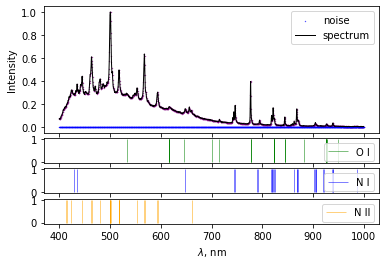

In [120]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, sharex=True, gridspec_kw={'height_ratios': [5, 1, 1, 1], 'hspace': 0.1})
show_spectrum( spectra['air'], 0, (400, 1000), plot = ax1) 

no_lines = spectrum_lines("data/no_lines.txt")
#show_all_spectrum_lines( no_lines, (400, 1000), plot = ax2)
show_named_spectrum_lines( no_lines, ('O I',), (400, 1000), plot = ax2)
show_named_spectrum_lines( no_lines, ('N I',), (400, 1000), plot = ax3)
show_named_spectrum_lines( no_lines, ('N II',), (400, 1000), plot = ax4)
ax2.legend()
ax3.legend()
ax4.legend()

ax1.set_ylabel( r"Intensity")
ax4.set_xlabel( r"$\lambda$, nm")

fig.savefig( 'gen/air_lines.pdf')
#no_lines

### Water spectra

164
1976
0
32
3
9
11
40


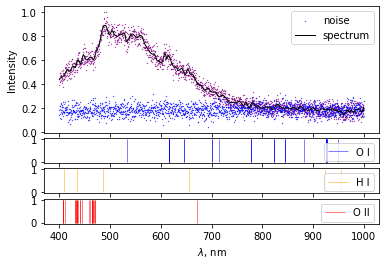

In [158]:
#show_spectrum( spectra['water'], 2.8, (350, 1000))

fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, sharex=True, gridspec_kw={'height_ratios': [5, 1, 1, 1], 'hspace': 0.1})
show_spectrum( spectra['water'], 2.8, (400, 1000), plot = ax1) 

no_lines = spectrum_lines("data/h2o_lines.txt")
#show_all_spectrum_lines( no_lines, (400, 1000), plot = ax2)
show_named_spectrum_lines( no_lines, ('O I',), (400, 1000), plot = ax2)
show_named_spectrum_lines( no_lines, ('H I',), (400, 1000), plot = ax3)
show_named_spectrum_lines( no_lines, ('O II',), (400, 1000), plot = ax4)
ax2.legend()
ax3.legend()
ax4.legend()

ax1.set_ylabel( r"Intensity")
ax4.set_xlabel( r"$\lambda$, nm")

fig.savefig( 'gen/water_lines.pdf')

### Lamp sharovaya Xe

1013
1805
5
24
AHTUNG!


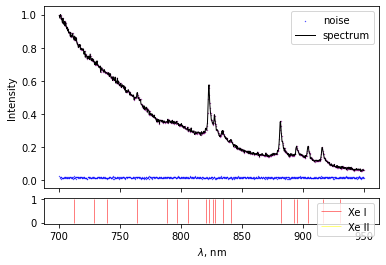

In [153]:
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [7, 1], 'hspace': 0.1})
show_spectrum( spectra['lamp_sharovaya'], 0, (700, 950), plot = ax1) 

xe_lines = spectrum_lines("data/xe_lines.txt", 26)
show_all_spectrum_lines( xe_lines, (700, 950), plot = ax2)

ax2.legend()

ax1.set_ylabel( r"Intensity")
ax2.set_xlabel( r"$\lambda$, nm")

fig.savefig( 'gen/xe_lines_spherical.pdf')


### Lamp tube Xe

1013
1976
15
40
AHTUNG!


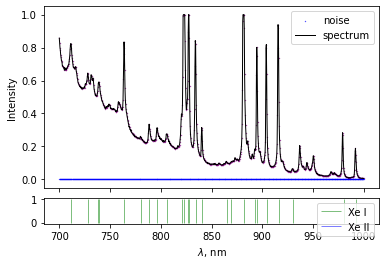

In [128]:
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [7, 1], 'hspace': 0.1})
show_spectrum( spectra['lamp_tube'], 0, (700, 1000), plot = ax1) 

xe_lines = spectrum_lines("data/xe_lines.txt", 40)
show_all_spectrum_lines( xe_lines, (700, 1000), plot = ax2)

ax2.legend()

ax1.set_ylabel( r"Intensity")
ax2.set_xlabel( r"$\lambda$, nm")

fig.savefig( 'gen/xe_lines.pdf')

In [125]:
cycler = itertools.cycle([1, 2])
next(cycler)  # 1
next(cycler)  # 1


2